In [1]:
import pandas as pd
import numpy as np
import os

import json

class Config():

    def __init__(self,fconfig):
        config = json.load(fconfig)
        self.name_main_sample = config['name_sample']
        self.name_sample = config['name_sample'] + config['additional_name']
        self.general_path = config['general_path']
        self.data_path = config['data_path']
        self.prediction_path = config['prediction_path']
        self.test_path = config['test_path'] ############
        self.flags = config['flags']
        self.hyperparam = config['hyperparam']
        self.features = config['features']
        self.name_class = config['name_class']
        self.name_class_column = config["name_class_column"]
        self.base = config["base"]
        self.picture = config['picture']
        self.statistic = config['statistic']
        #
        self.path_ml_data = f'{self.general_path}/ml/data'
        self.path_ml = f'{self.general_path}/ml'
        self.path_sample = f'{self.general_path}/sample'
        self.path_pic = f'{self.general_path}/ml/picture'
        self.path_stat = f'{self.general_path}/statistic'
        #
        self.path_model = f"{self.path_ml}/model/mod_{self.name_sample}"
        self.path_weight = f"{self.path_ml}/model/weight_{self.name_sample}"
        self.path_eval = f"{self.path_ml}/eval/{self.name_sample}"
        self.path_predict = f"{self.path_ml}/prediction/{self.name_sample}"
        #
        columns = []
        columns_prob = []
        for col in self.name_class:
            columns.append(f"{col}_cls")
            columns_prob.append(f"{col}_cls_prob")
        self.name_class_cls = columns
        self.name_class_prob = columns_prob

In [2]:
fconfig = open('config_agn_sdss_fuzzy_None.json')
config_None = Config(fconfig)
fconfig.close()
del fconfig

fconfig = open('config_agn_sdss_fuzzy_err.json')
config_fuzzy_err = Config(fconfig)
fconfig.close()
del fconfig

fconfig = open('config_agn_sdss_fuzzy_dist.json')
config_fuzzy_dist = Config(fconfig)
fconfig.close()
del fconfig

In [2]:
from data_process import data_preparation

def select_data(config):
    #data = pd.DataFrame()
    #data preparation
    if(not config.flags['data_preprocessing']['work']):
        if(os.path.isfile(f'{config.path_ml_data}/{config.name_main_sample}_all.csv')):
            data = pd.read_csv(f'{config.path_ml_data}/{config.name_main_sample}_all.csv', header = 0, sep = ',')
        else:
            data = data_preparation(config.path_ml_data,config.path_sample,config.name_class,config)
    else:
        data = data_preparation(config.path_ml_data,config.path_sample,config.name_class,config)
    
    return data

In [3]:
from network import NN
from data_process import data_preparation, get_features

#network training
def network(data,config):
    #features from config
    #name from config
    print('Sample name: ', config.name_sample)
    print('Features: ', config.features["data"])
    
    #hyperparams from config
    batch_size = config.hyperparam['batch_size']
    num_ep = config.hyperparam['num_ep']
    optimizer = config.hyperparam['optimizer']
    loss = config.hyperparam['loss']
    validation_split = config.hyperparam['validation_split']
    
    #balanced class
    class_weights = None
    if(config.hyperparam["model_variable"]["balanced"]):
        from sklearn.utils import class_weight
        y = np.zeros(data.shape[0])
        cl = np.array(data[config.name_class_cls].values)
        #print(cl)
        for i in range(data.shape[0]):
            y[i] = np.argmax(cl[i,:])
        class_weights = dict(enumerate(class_weight.compute_class_weight(class_weight = 'balanced',classes = np.unique(y),y = y)))
        print("class weights",class_weights)
        del y, cl

    print(data)

    print("Features mode list:\t",config.features["train"])
    features = get_features(config.features["train"],config)
    print("Features train values:\t",features)
    
    #sample_weight
    sample_weight = None
    if(config.hyperparam["model_variable"]["sample_weight"] in config.flags['data_preprocessing']['main_sample']['weight']['method']):
        #sample_weight = data[config.hyperparam["model_variable"]["sample_weight"]].values
        sample_weight = data[config.hyperparam["model_variable"]["sample_weight"]].values.T[:]
        print(sample_weight)

    try:
        data[features]
    except:
        raise Exception("data don't have initiated features, check config.features['train'] value and WARNINGs above")

    if(config.hyperparam["model_variable"]["work"]):
        NN(data[features],data[config.name_class_cls],data['z'],sample_weight,validation_split,batch_size,num_ep,optimizer,loss,class_weights,
        output_path_predict = config.path_predict,
        output_path_mod = config.path_model,
        output_path_weight = config.path_weight,
        path_save_eval = config.path_eval,
        config=config)

2024-05-09 14:57:36.291926: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
data = select_data(config_None)

data

,RA,DEC,z,z_err,angDist,angDist.1,PQSO,PGal,PSS,nW1,...,mcd_d,mcd_g,fuzzy_err,fuzzy_dist,qso_cls,agn_cls,sbg_cls,sfg_cls,gal_cls,star_cls
0,239.177460,27.055966,0.090353,0.000027,0.086462,0.171325,0.000000,1.000000,0.000000,12,...,2.357481,0.340302,0.687168,0.787404,0,0,0,0,1,0
1,169.268150,4.427474,1.170077,0.000150,0.032336,0.068488,1.000000,0.000000,0.000000,12,...,0.837587,0.263093,0.681880,0.827843,1,0,0,0,0,0
2,43.250305,-3.342976,0.244153,0.000030,0.200110,0.594563,0.000336,0.013068,0.984260,13,...,1.140024,0.338401,0.654243,0.815071,0,0,0,0,1,0
3,172.780700,45.426833,1.229971,0.000552,0.045566,0.092679,0.999922,0.000000,0.000078,12,...,1.358093,0.379193,0.672553,0.808466,1,0,0,0,0,0
4,150.185940,2.474568,0.000868,0.000008,0.124031,0.150412,0.000000,0.000000,0.999934,12,...,0.739153,0.254910,0.702885,0.882802,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090354,219.531190,15.218142,0.098927,0.000009,0.011590,0.030389,0.000000,1.000000,0.000000,13,...,2.128290,0.438617,0.677479,0.554826,0,0,0,1,0,0
1090355,9.150885,23.917155,2.520883,0.000440,0.045041,0.395291,1.000000,0.000000,0.000000,13,...,3.519597,0.078064,0.642015,0.640678,1,0,0,0,0,0
1090356,33.514822,6.673856,-0.000333,0.000012,0.065429,0.236262,0.000000,0.000000,0.999985,13,...,3.740190,0.071538,0.565084,0.879244,0,0,0,0,0,1
1090357,3.715578,4.087570,1.855977,0.000165,0.068224,0.877788,1.000000,0.000000,0.000000,13,...,1.609952,0.407870,0.639610,0.800421,1,0,0,0,0,0


In [6]:
#network(data,config_None)
network(data,config_fuzzy_err)
network(data,config_fuzzy_dist)

Sample name:  sdss_diploma_sample_dereddedcut_rangecut_flux_color_mcdcut_cbalancedfalse_wbalanced_e20_v02_arelu_erecall_ldropout_fuzzy_err
Features:  {'astrometry': ['angDist', 'PQSO', 'PGal', 'PSS'], 'flux': ['nW1', 'FW1pm', 'e_FW1pm', 'nW2', 'FW2pm', 'e_FW2pm', 'o_Gmag', 'FG', 'e_FG', 'o_BPmag', 'FBP', 'e_FBP', 'o_RPmag', 'FRP', 'e_FRP'], 'photometry': ['W1mproPM', 'e_W1mproPM', 'W2mproPM', 'e_W2mproPM', 'Gmag', 'e_Gmag', 'BPmag', 'e_BPmag', 'RPmag', 'e_RPmag']}
class weights {0: 0.5069758293997523, 1: 11.318292227204783, 2: 8.05632397925256, 3: 2.162741294361269, 4: 0.48256051706374076, 5: 0.7810146982980918}
                 RA        DEC         z     z_err   angDist  angDist.1   
0        239.177460  27.055966  0.090353  0.000027  0.086462   0.171325  \
1        169.268150   4.427474  1.170077  0.000150  0.032336   0.068488   
2         43.250305  -3.342976  0.244153  0.000030  0.200110   0.594563   
3        172.780700  45.426833  1.229971  0.000552  0.045566   0.092679   
4    

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0

gpu
model compiled
Epoch 1/20
639/639 [==============================] - 21s 31ms/step - loss: 0.5088 - tp: 602647.0000 - fp: 48124.0000 - tn: 4040721.0000 - fn: 215122.0000 - accuracy: 0.9463 - precision: 0.9261 - recall: 0.7369 - auc: 0.9771 - prc: 0.9206 - weighted_accuracy: 0.6636 - val_loss: 0.2270 - val_tp: 135852.0000 - val_fp: 6454.0000 - val_tn: 811316.0000 - val_fn: 27702.0000 - val_accuracy: 0.9652 - val_precision: 0.9546 - val_recall: 0.8306 - val_auc: 0.9895 - val_prc: 0.9616 - val_weighted_accuracy: 0.9031
Epoch 2/20
639/639 [==============================] - 1s 2ms/step - loss: 0.4011 - tp: 522388.0000 - fp: 37737.0000 - tn: 3233338.0000 - fn: 131827.0000 - accuracy: 0.9568 - precision: 0.9326 - recall: 0.7985 - auc: 0.9852 - prc: 0.9462 - weighted_accuracy: 0.7366 - val_loss: 0.2036 - val_tp: 141045.0000 - val_fp: 8189.0000 - val_tn: 809581.0000 - val_fn: 22509.0000 - val_accuracy: 0.9687 - val_precision: 0.9451 - val_recall: 0.8624 - val_auc: 0.9913 - val_prc: 0.9676 -

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.8s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0

gpu
model compiled
Epoch 1/20
639/639 [==============================] - 20s 31ms/step - loss: 0.5048 - tp: 599657.0000 - fp: 43343.0000 - tn: 4045502.0000 - fn: 218112.0000 - accuracy: 0.9467 - precision: 0.9326 - recall: 0.7333 - auc: 0.9772 - prc: 0.9217 - weighted_accuracy: 0.6677 - val_loss: 0.1960 - val_tp: 141570.0000 - val_fp: 7509.0000 - val_tn: 810261.0000 - val_fn: 21984.0000 - val_accuracy: 0.9699 - val_precision: 0.9496 - val_recall: 0.8656 - val_auc: 0.9919 - val_prc: 0.9699 - val_weighted_accuracy: 0.9134
Epoch 2/20
639/639 [==============================] - 1s 2ms/step - loss: 0.4028 - tp: 521624.0000 - fp: 37940.0000 - tn: 3233135.0000 - fn: 132591.0000 - accuracy: 0.9566 - precision: 0.9322 - recall: 0.7973 - auc: 0.9847 - prc: 0.9450 - weighted_accuracy: 0.7377 - val_loss: 0.2102 - val_tp: 141139.0000 - val_fp: 8278.0000 - val_tn: 809492.0000 - val_fn: 22415.0000 - val_accuracy: 0.9687 - val_precision: 0.9446 - val_recall: 0.8630 - val_auc: 0.9907 - val_prc: 0.9658 -

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.5s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0

gpu
model compiled
Epoch 1/20
639/639 [==============================] - 21s 31ms/step - loss: 0.5303 - tp: 585722.0000 - fp: 49918.0000 - tn: 4038932.0000 - fn: 232048.0000 - accuracy: 0.9425 - precision: 0.9215 - recall: 0.7162 - auc: 0.9736 - prc: 0.9107 - weighted_accuracy: 0.6512 - val_loss: 0.2146 - val_tp: 138244.0000 - val_fp: 8729.0000 - val_tn: 809041.0000 - val_fn: 25310.0000 - val_accuracy: 0.9653 - val_precision: 0.9406 - val_recall: 0.8452 - val_auc: 0.9901 - val_prc: 0.9634 - val_weighted_accuracy: 0.8979
Epoch 2/20
639/639 [==============================] - 1s 2ms/step - loss: 0.4038 - tp: 516748.0000 - fp: 38572.0000 - tn: 3232508.0000 - fn: 137468.0000 - accuracy: 0.9552 - precision: 0.9305 - recall: 0.7899 - auc: 0.9845 - prc: 0.9437 - weighted_accuracy: 0.7364 - val_loss: 0.2549 - val_tp: 131550.0000 - val_fp: 10289.0000 - val_tn: 807481.0000 - val_fn: 32004.0000 - val_accuracy: 0.9569 - val_precision: 0.9275 - val_recall: 0.8043 - val_auc: 0.9852 - val_prc: 0.9466 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.5s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0

gpu
model compiled
Epoch 1/20
852/852 [==============================] - 27s 31ms/step - loss: 0.4906 - tp: 764346.0000 - fp: 54480.0000 - tn: 5124725.0000 - fn: 271495.0000 - accuracy: 0.9476 - precision: 0.9335 - recall: 0.7379 - auc: 0.9779 - prc: 0.9239 - weighted_accuracy: 0.6749 - val_loss: 0.2427 - val_tp: 178021.0000 - val_fp: 13589.0000 - val_tn: 1076771.0000 - val_fn: 40051.0000 - val_accuracy: 0.9590 - val_precision: 0.9291 - val_recall: 0.8163 - val_auc: 0.9871 - val_prc: 0.9529 - val_weighted_accuracy: 0.8841
Epoch 2/20
852/852 [==============================] - 2s 2ms/step - loss: 0.3902 - tp: 697726.0000 - fp: 51727.0000 - tn: 4309708.0000 - fn: 174561.0000 - accuracy: 0.9568 - precision: 0.9310 - recall: 0.7999 - auc: 0.9857 - prc: 0.9474 - weighted_accuracy: 0.7462 - val_loss: 0.1977 - val_tp: 188833.0000 - val_fp: 12824.0000 - val_tn: 1077536.0000 - val_fn: 29239.0000 - val_accuracy: 0.9679 - val_precision: 0.9364 - val_recall: 0.8659 - val_auc: 0.9912 - val_prc: 0.96

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.9s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.6s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.8s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    1.2s finished


Sample name:  sdss_diploma_sample_dereddedcut_rangecut_flux_color_mcdcut_cbalancedfalse_wbalanced_e20_v02_arelu_erecall_ldropout_fuzzy_dist
Features:  {'astrometry': ['angDist', 'PQSO', 'PGal', 'PSS'], 'flux': ['nW1', 'FW1pm', 'e_FW1pm', 'nW2', 'FW2pm', 'e_FW2pm', 'o_Gmag', 'FG', 'e_FG', 'o_BPmag', 'FBP', 'e_FBP', 'o_RPmag', 'FRP', 'e_FRP'], 'photometry': ['W1mproPM', 'e_W1mproPM', 'W2mproPM', 'e_W2mproPM', 'Gmag', 'e_Gmag', 'BPmag', 'e_BPmag', 'RPmag', 'e_RPmag']}
class weights {0: 0.5069758293997523, 1: 11.318292227204783, 2: 8.05632397925256, 3: 2.162741294361269, 4: 0.48256051706374076, 5: 0.7810146982980918}
                 RA        DEC         z     z_err   angDist  angDist.1   
0        239.177460  27.055966  0.090353  0.000027  0.086462   0.171325  \
1        169.268150   4.427474  1.170077  0.000150  0.032336   0.068488   
2         43.250305  -3.342976  0.244153  0.000030  0.200110   0.594563   
3        172.780700  45.426833  1.229971  0.000552  0.045566   0.092679   
4   

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0

gpu
model compiled
Epoch 1/20
639/639 [==============================] - 21s 31ms/step - loss: 0.5677 - tp: 604262.0000 - fp: 45987.0000 - tn: 4042858.0000 - fn: 213507.0000 - accuracy: 0.9471 - precision: 0.9293 - recall: 0.7389 - auc: 0.9767 - prc: 0.9207 - weighted_accuracy: 0.6826 - val_loss: 0.2287 - val_tp: 140502.0000 - val_fp: 6978.0000 - val_tn: 810792.0000 - val_fn: 23052.0000 - val_accuracy: 0.9694 - val_precision: 0.9527 - val_recall: 0.8591 - val_auc: 0.9908 - val_prc: 0.9662 - val_weighted_accuracy: 0.9151
Epoch 2/20
639/639 [==============================] - 1s 2ms/step - loss: 0.4456 - tp: 521453.0000 - fp: 37238.0000 - tn: 3233837.0000 - fn: 132762.0000 - accuracy: 0.9567 - precision: 0.9333 - recall: 0.7971 - auc: 0.9846 - prc: 0.9448 - weighted_accuracy: 0.7530 - val_loss: 0.2385 - val_tp: 138574.0000 - val_fp: 8220.0000 - val_tn: 809550.0000 - val_fn: 24980.0000 - val_accuracy: 0.9662 - val_precision: 0.9440 - val_recall: 0.8473 - val_auc: 0.9899 - val_prc: 0.9630 -

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.6s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0

gpu
model compiled
Epoch 1/20
639/639 [==============================] - 21s 31ms/step - loss: 0.6020 - tp: 595335.0000 - fp: 57717.0000 - tn: 4031128.0000 - fn: 222434.0000 - accuracy: 0.9429 - precision: 0.9116 - recall: 0.7280 - auc: 0.9737 - prc: 0.9109 - weighted_accuracy: 0.6673 - val_loss: 0.2307 - val_tp: 139252.0000 - val_fp: 7457.0000 - val_tn: 810313.0000 - val_fn: 24302.0000 - val_accuracy: 0.9676 - val_precision: 0.9492 - val_recall: 0.8514 - val_auc: 0.9903 - val_prc: 0.9649 - val_weighted_accuracy: 0.9132
Epoch 2/20
639/639 [==============================] - 1s 2ms/step - loss: 0.4573 - tp: 519210.0000 - fp: 41367.0000 - tn: 3229708.0000 - fn: 135005.0000 - accuracy: 0.9551 - precision: 0.9262 - recall: 0.7936 - auc: 0.9840 - prc: 0.9422 - weighted_accuracy: 0.7468 - val_loss: 0.2314 - val_tp: 140365.0000 - val_fp: 8868.0000 - val_tn: 808902.0000 - val_fn: 23189.0000 - val_accuracy: 0.9673 - val_precision: 0.9406 - val_recall: 0.8582 - val_auc: 0.9902 - val_prc: 0.9641 -

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.6s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0

gpu
model compiled
Epoch 1/20
639/639 [==============================] - 21s 31ms/step - loss: 0.5791 - tp: 600915.0000 - fp: 58472.0000 - tn: 4030378.0000 - fn: 216855.0000 - accuracy: 0.9439 - precision: 0.9113 - recall: 0.7348 - auc: 0.9747 - prc: 0.9142 - weighted_accuracy: 0.6822 - val_loss: 0.2389 - val_tp: 138154.0000 - val_fp: 9912.0000 - val_tn: 807858.0000 - val_fn: 25400.0000 - val_accuracy: 0.9640 - val_precision: 0.9331 - val_recall: 0.8447 - val_auc: 0.9897 - val_prc: 0.9614 - val_weighted_accuracy: 0.9063
Epoch 2/20
639/639 [==============================] - 1s 2ms/step - loss: 0.4469 - tp: 522033.0000 - fp: 41057.0000 - tn: 3230023.0000 - fn: 132183.0000 - accuracy: 0.9559 - precision: 0.9271 - recall: 0.7980 - auc: 0.9845 - prc: 0.9438 - weighted_accuracy: 0.7535 - val_loss: 0.2724 - val_tp: 133324.0000 - val_fp: 10190.0000 - val_tn: 807580.0000 - val_fn: 30230.0000 - val_accuracy: 0.9588 - val_precision: 0.9290 - val_recall: 0.8152 - val_auc: 0.9862 - val_prc: 0.9498 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0

gpu
model compiled
Epoch 1/20
852/852 [==============================] - 27s 31ms/step - loss: 0.5524 - tp: 769516.0000 - fp: 63959.0000 - tn: 5115246.0000 - fn: 266325.0000 - accuracy: 0.9469 - precision: 0.9233 - recall: 0.7429 - auc: 0.9776 - prc: 0.9223 - weighted_accuracy: 0.6900 - val_loss: 0.2464 - val_tp: 183322.0000 - val_fp: 12503.0000 - val_tn: 1077857.0000 - val_fn: 34750.0000 - val_accuracy: 0.9639 - val_precision: 0.9362 - val_recall: 0.8406 - val_auc: 0.9890 - val_prc: 0.9596 - val_weighted_accuracy: 0.9085
Epoch 2/20
852/852 [==============================] - 2s 2ms/step - loss: 0.4366 - tp: 699994.0000 - fp: 52339.0000 - tn: 4309096.0000 - fn: 172293.0000 - accuracy: 0.9571 - precision: 0.9304 - recall: 0.8025 - auc: 0.9851 - prc: 0.9461 - weighted_accuracy: 0.7592 - val_loss: 0.2287 - val_tp: 186148.0000 - val_fp: 12054.0000 - val_tn: 1078306.0000 - val_fn: 31924.0000 - val_accuracy: 0.9664 - val_precision: 0.9392 - val_recall: 0.8536 - val_auc: 0.9903 - val_prc: 0.96

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0

In [3]:
from statistic import metric_sklearn, metric_, main_metrics, kfold_metrics

2024-05-10 20:35:46.069987: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
def picture_metrics(one_ml_cycle_main_mass,one_ml_cycle_all_kfold_mass,picture_label,config):
    a,b = 2,2
    from matplotlib import pyplot as plt
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    def pic(axs,i,j,l,one_ml_cycle_main,one_ml_cycle_all_kfold):

        axs[i,j].scatter(index_mass,one_ml_cycle_main.loc[index[i*b+j],:],lw=5, label=f"main_{picture_label[l]}", color = colors[l])
        axs[i,j].plot(index_mass,one_ml_cycle_main.loc[index[i*b+j],:],lw=2, color = colors[l])
        #axs[i,j].plot(index_mass,one_ml_cycle_all_kfold.loc[idx[index[i*b+j],'mean'],:], lw=5)
        axs[i,j].errorbar(index_mass,one_ml_cycle_all_kfold.loc[idx[index[i*b+j],'mean'],:],
                        yerr=[one_ml_cycle_all_kfold.loc[idx[index[i*b+j],'mean'],:].values - one_ml_cycle_all_kfold.loc[idx[index[i*b+j],'min'],:].values,
                                one_ml_cycle_all_kfold.loc[idx[index[i*b+j],'max'],:].values - one_ml_cycle_all_kfold.loc[idx[index[i*b+j],'mean'],:].values], 
                        fmt='o', markersize=10, elinewidth=3, capsize=20, capthick=3, label=f"kfold_{picture_label[l]}", color = colors[l])

    index = ['precision','recall','f1','bacc','k','mcc','roc']
    idx = pd.IndexSlice

    fig=plt.figure()
    fig, axs = plt.subplots(a,b)

    index_mass = [config.name_class[i] for i in range(len(config.name_class))]
    for i in range(a):
        for j in range(b):
            #
            for l in range(len(one_ml_cycle_main_mass)):
                pic(axs,i,j,l,one_ml_cycle_main_mass[l],one_ml_cycle_all_kfold_mass[l])
            #
            axs[i,j].tick_params(axis='x', labelsize=30)
            axs[i,j].tick_params(axis='y', labelsize=30)
            axs[i,j].set_xlabel(index[i*b+j],fontsize=40)
            axs[i,j].legend(prop={'size': 20})
            axs[i,j].set_ylim([0.0,1.1])
    
    axs[1,1].set_ylim([0.4,1.1])

    fig.set_size_inches(30,20)
    plt.show()

In [4]:
%%time
one_ml_cycle_all_kfold_None_1 = kfold_metrics(True,config_None)
one_ml_cycle_all_kfold_fuzzy_err_1 = kfold_metrics(True,config_fuzzy_err)
one_ml_cycle_all_kfold_fuzzy_dist_1 = kfold_metrics(True,config_fuzzy_dist)

CPU times: user 1min 51s, sys: 231 ms, total: 1min 51s
Wall time: 1min 51s


In [9]:
%%time
one_ml_cycle_all_kfold_None = kfold_metrics(False,config_None)
one_ml_cycle_all_kfold_fuzzy_err = kfold_metrics(False,config_fuzzy_err)
one_ml_cycle_all_kfold_fuzzy_dist = kfold_metrics(False,config_fuzzy_dist)

CPU times: user 21.6 s, sys: 75.4 ms, total: 21.7 s
Wall time: 21.7 s


In [5]:
%%time
one_ml_cycle_main_None_1, one_ml_cycle_main_metr_None_1 = main_metrics(True,config_None)
one_ml_cycle_main_fuzzy_err_1, one_ml_cycle_main_metr_fuzzy_err_1 = main_metrics(True,config_fuzzy_err)
one_ml_cycle_main_fuzzy_dist_1, one_ml_cycle_main_metr_fuzzy_dist_1 = main_metrics(True,config_fuzzy_dist)

CPU times: user 1min 58s, sys: 424 ms, total: 1min 58s
Wall time: 1min 58s


In [11]:
one_ml_cycle_main_None, one_ml_cycle_main_metr_None = main_metrics(False,config_None)
one_ml_cycle_main_fuzzy_err, one_ml_cycle_main_metr_fuzzy_err = main_metrics(False,config_fuzzy_err)
one_ml_cycle_main_fuzzy_dist, one_ml_cycle_main_metr_fuzzy_dist = main_metrics(False,config_fuzzy_dist)

In [12]:
one_ml_cycle_main_mass = [one_ml_cycle_main_None,one_ml_cycle_main_fuzzy_err,one_ml_cycle_main_fuzzy_dist,
                          one_ml_cycle_main_None_1,one_ml_cycle_main_fuzzy_err_1,one_ml_cycle_main_fuzzy_dist_1]
one_ml_cycle_all_kfold_mass = [one_ml_cycle_all_kfold_None,one_ml_cycle_all_kfold_fuzzy_err,one_ml_cycle_all_kfold_fuzzy_dist,
                               one_ml_cycle_all_kfold_None_1,one_ml_cycle_all_kfold_fuzzy_err_1,one_ml_cycle_all_kfold_fuzzy_dist_1]
picture_label = ["None","fuzzy_err","fuzzy_dist","None_1","fuzzy_err_1","fuzzy_dist_1"]

In [28]:
one_ml_cycle_main_mass = [one_ml_cycle_main_None,one_ml_cycle_main_fuzzy_err,one_ml_cycle_main_fuzzy_dist]
one_ml_cycle_all_kfold_mass = [one_ml_cycle_all_kfold_None,one_ml_cycle_all_kfold_fuzzy_err,one_ml_cycle_all_kfold_fuzzy_dist]
picture_label = ["None","fuzzy_err","fuzzy_dist"]

<h2>threshold = 0.5</h2>

<Figure size 640x480 with 0 Axes>

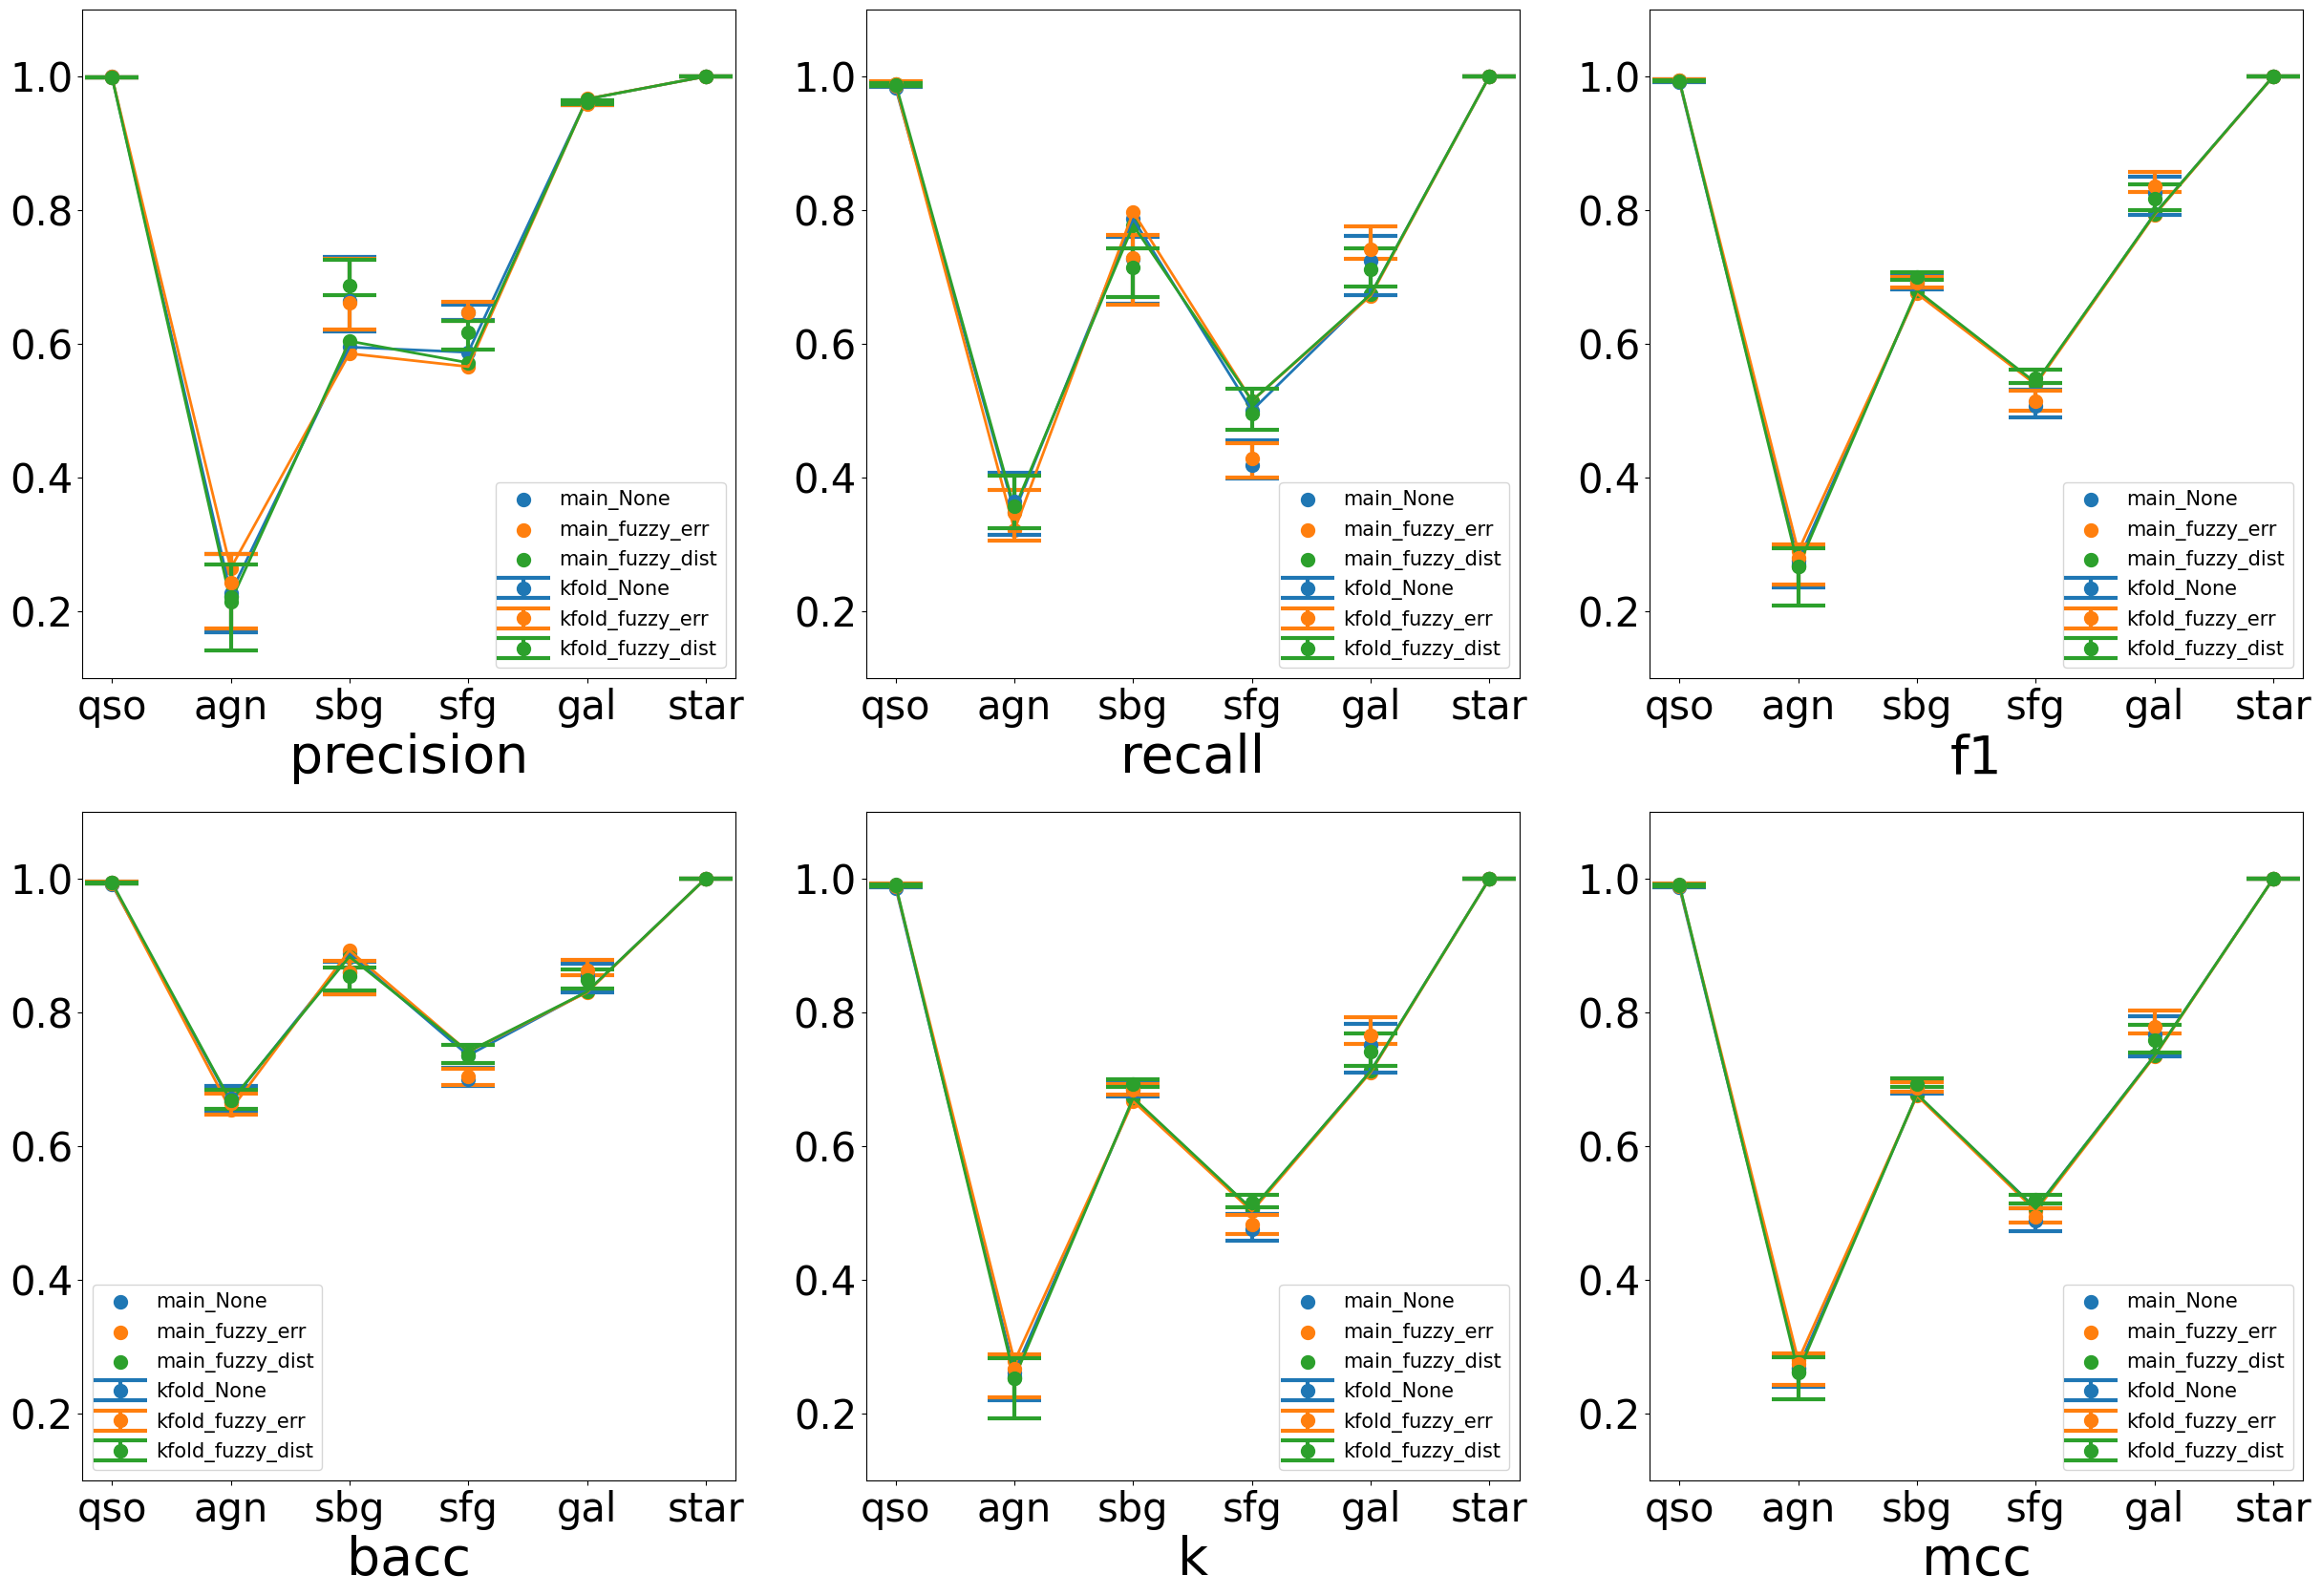

In [29]:
picture_metrics(one_ml_cycle_main_mass,one_ml_cycle_all_kfold_mass,picture_label,config_None)

<h2>argmax</h2>

In [6]:
one_ml_cycle_main_mass = [one_ml_cycle_main_None_1,one_ml_cycle_main_fuzzy_err_1,one_ml_cycle_main_fuzzy_dist_1]
one_ml_cycle_all_kfold_mass = [one_ml_cycle_all_kfold_None_1,one_ml_cycle_all_kfold_fuzzy_err_1,one_ml_cycle_all_kfold_fuzzy_dist_1]
picture_label = ["None","fuzzy_err","fuzzy_dist"]

<Figure size 640x480 with 0 Axes>

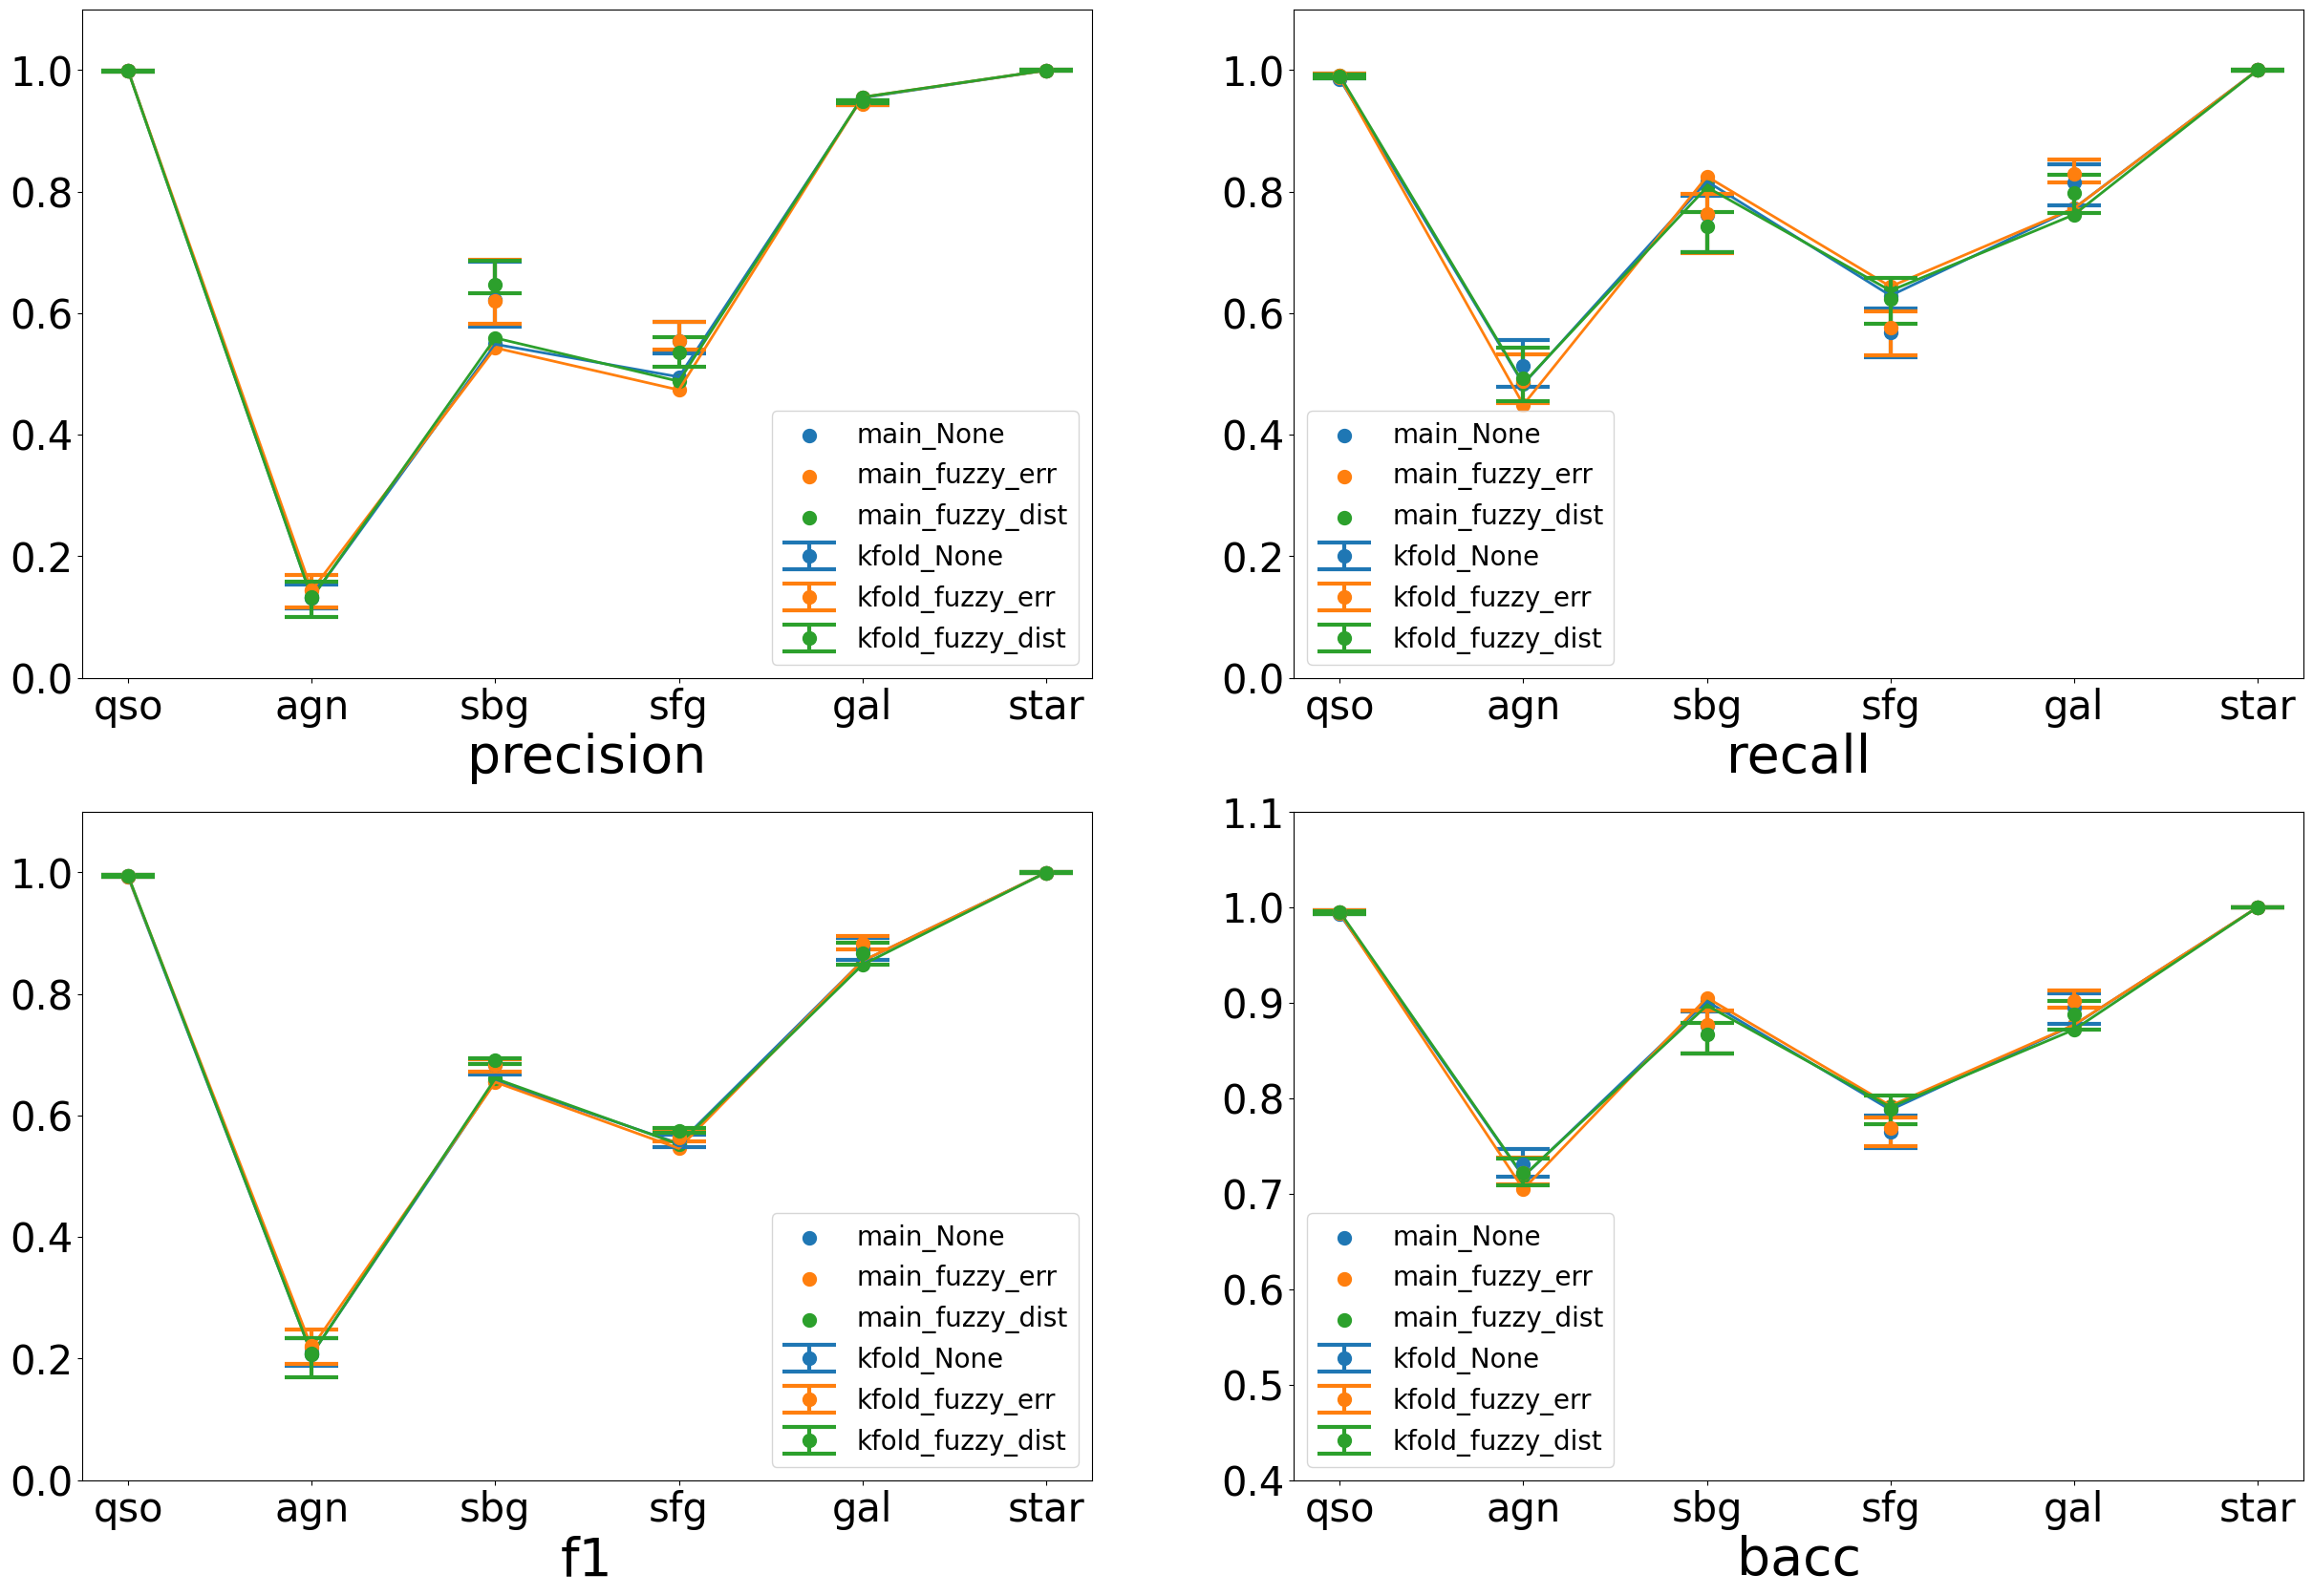

In [9]:
picture_metrics(one_ml_cycle_main_mass,one_ml_cycle_all_kfold_mass,picture_label,config_None)

In [10]:
def redshift_estimation(config):
    from network import make_custom_index
    from matplotlib import pyplot as plt
    def redshift_estimation_picture(ax,data,title):
        bins = 100
        data['sigma'] = abs(data['redshift_pred']-data['actual_redshift'])/(1+data["actual_redshift"])
        #https://www.aanda.org/articles/aa/full_html/2018/11/aa30763-17/aa30763-17.html#R29
        sigma_NMAD = 1.48 * data['sigma'].median(axis=0)

        min = data['actual_redshift'].min()
        max = data['actual_redshift'].max()
        #line 
        redshift_line = lambda x,sign: x + sign*0.15*(1+x)
        line_base_array = np.linspace(min,max,num=bins)
        line_value_dw_array = redshift_line(line_base_array,-1)
        line_value_up_array = redshift_line(line_base_array,1)


        ax.scatter(data['redshift_pred'],data['actual_redshift'], color='r', s=1)

        ax.plot(line_base_array, line_value_dw_array, color = 'black', linestyle="dashed")
        ax.plot(line_base_array, line_value_up_array, color = 'black', linestyle="dashed")

        ax.plot(line_base_array, line_base_array, color="black")
        
        ax.text(line_base_array[0],line_value_up_array[3] + line_value_up_array[bins//2]*0.15 ,r"$|z_{pred}-z_{spec}| > 0.15*(1 + z_{spec})$", fontsize=22, weight='bold', rotation=180*np.arctan((line_value_up_array[-1]-line_value_up_array[0])/(max-min))/np.pi - 3)
        l = r"$\sigma_{NMAD}$"
        ax.text(min,max+(max-min)*0.05,f"{l} = {sigma_NMAD}", fontsize = 20)

        count_outlire = data[(data['redshift_pred'] > redshift_line(data['actual_redshift'],1)) | (data['redshift_pred'] < redshift_line(data['actual_redshift'],-1))].shape[0]
        persent = round((count_outlire/data.shape[0])*100,3)
        ax.text((max-min)*1.2/2 + min,min-(max-min)*0.05,f"Outlire, % = {persent}", fontsize = 20)

        ax.set_title(title, fontsize=20)
        ax.tick_params(axis='x', labelsize=20)
        ax.tick_params(axis='y', labelsize=20)

        ax.set_xlabel("Prediction value", fontsize = 20)
        ax.set_ylabel("Actual value", fontsize = 20)

    fig, ax = plt.subplots(1,2)

    fig.set_size_inches(20,10)
    
    title = ['main', '2nd kfold']

    for i, index in enumerate(['00','2']):
        name = make_custom_index(index,config.hyperparam["model_variable"]["neuron_count"])
        class_name = 'qso_cls' #config.name_class_cls:
        try:
            data = pd.read_csv(f"{config.path_eval}_{name}_{class_name}_redshift.csv", header=0, sep=",")
        except:
            raise Exception(f"redshift estimation is not defined\nplease check config.hyperparam['redshift']['work']\n{config.path_predict}_{name}_redshift.csv")
        redshift_estimation_picture(ax[i], data, f"{title[i]} for QSO")

    fig.savefig(f"{config.path_pic}/{config.name_sample}_bound_redshift.png")
    plt.show()
    plt.close(fig)

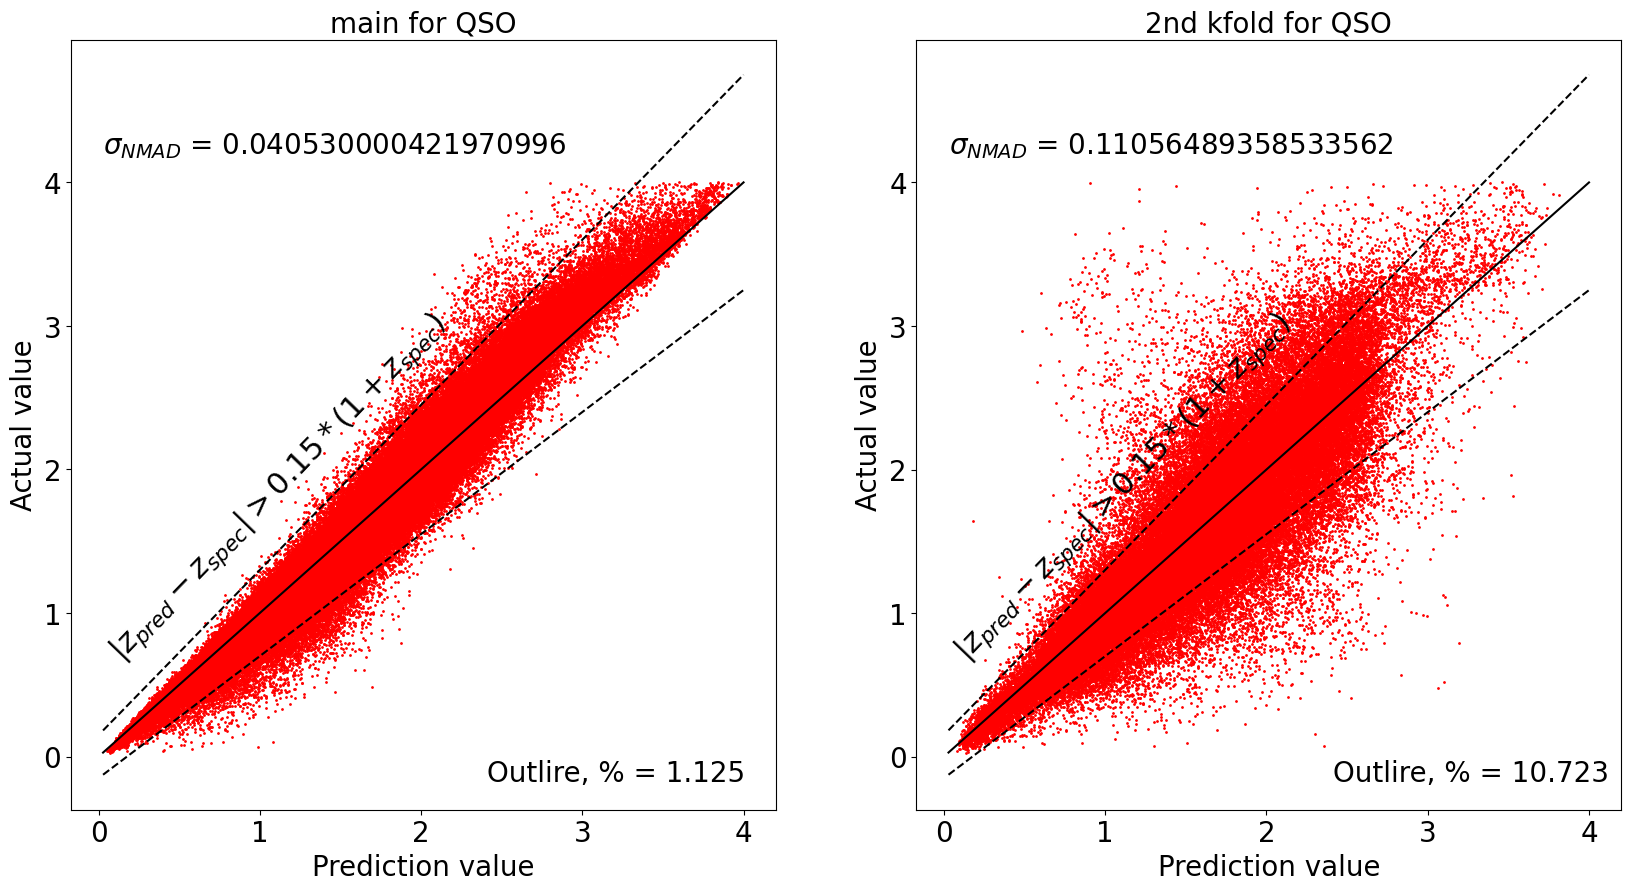

In [35]:
redshift_estimation(config_None)

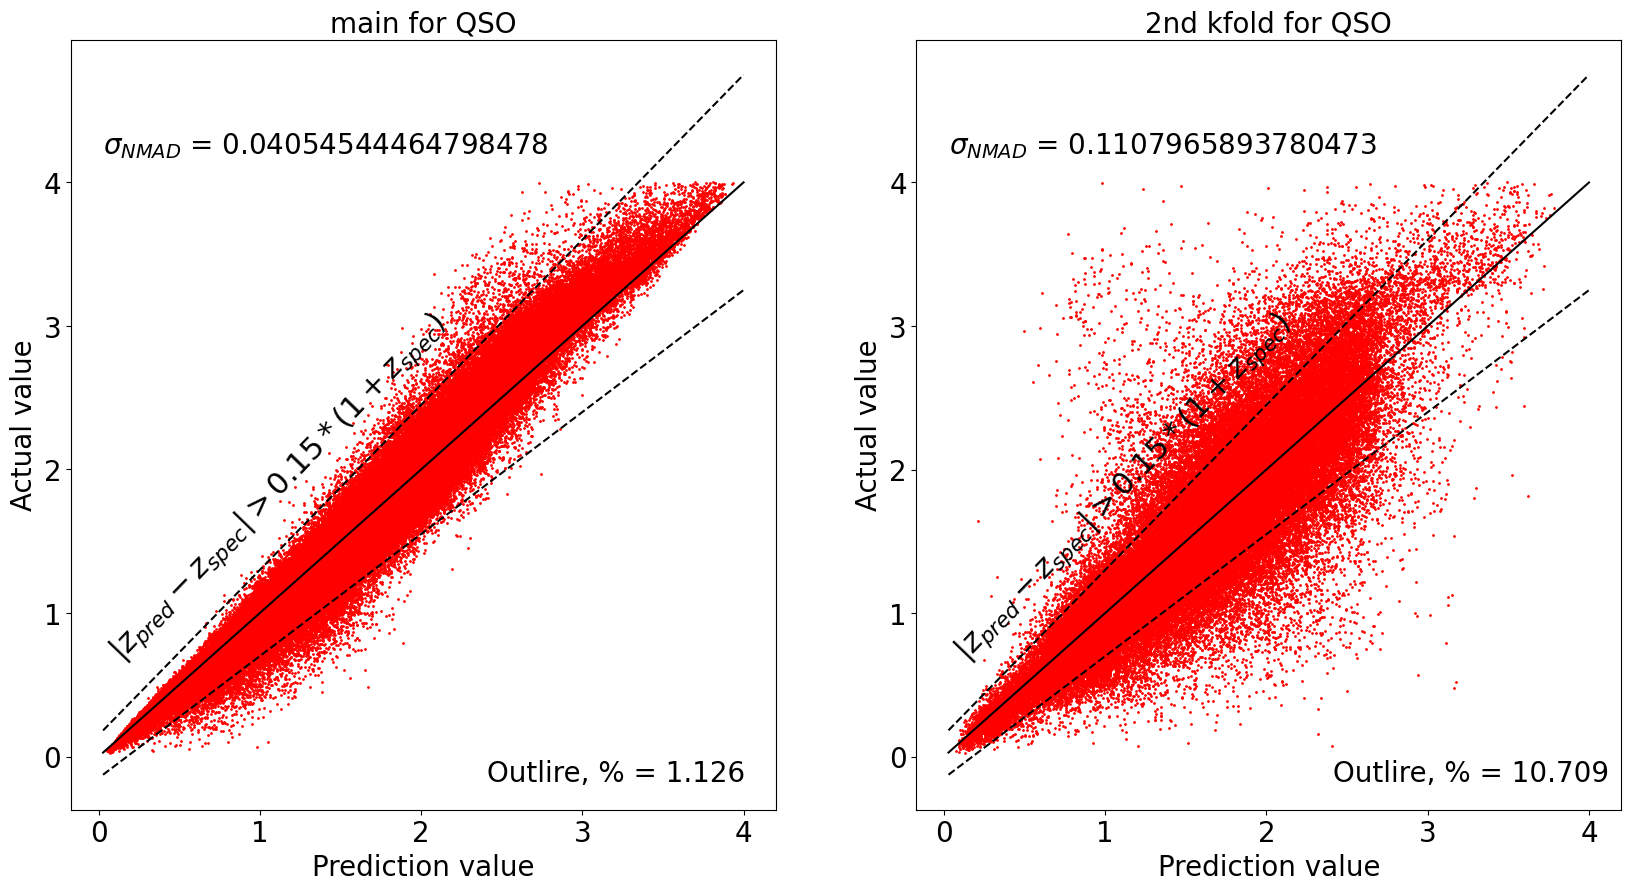

In [22]:
redshift_estimation(config_fuzzy_err)

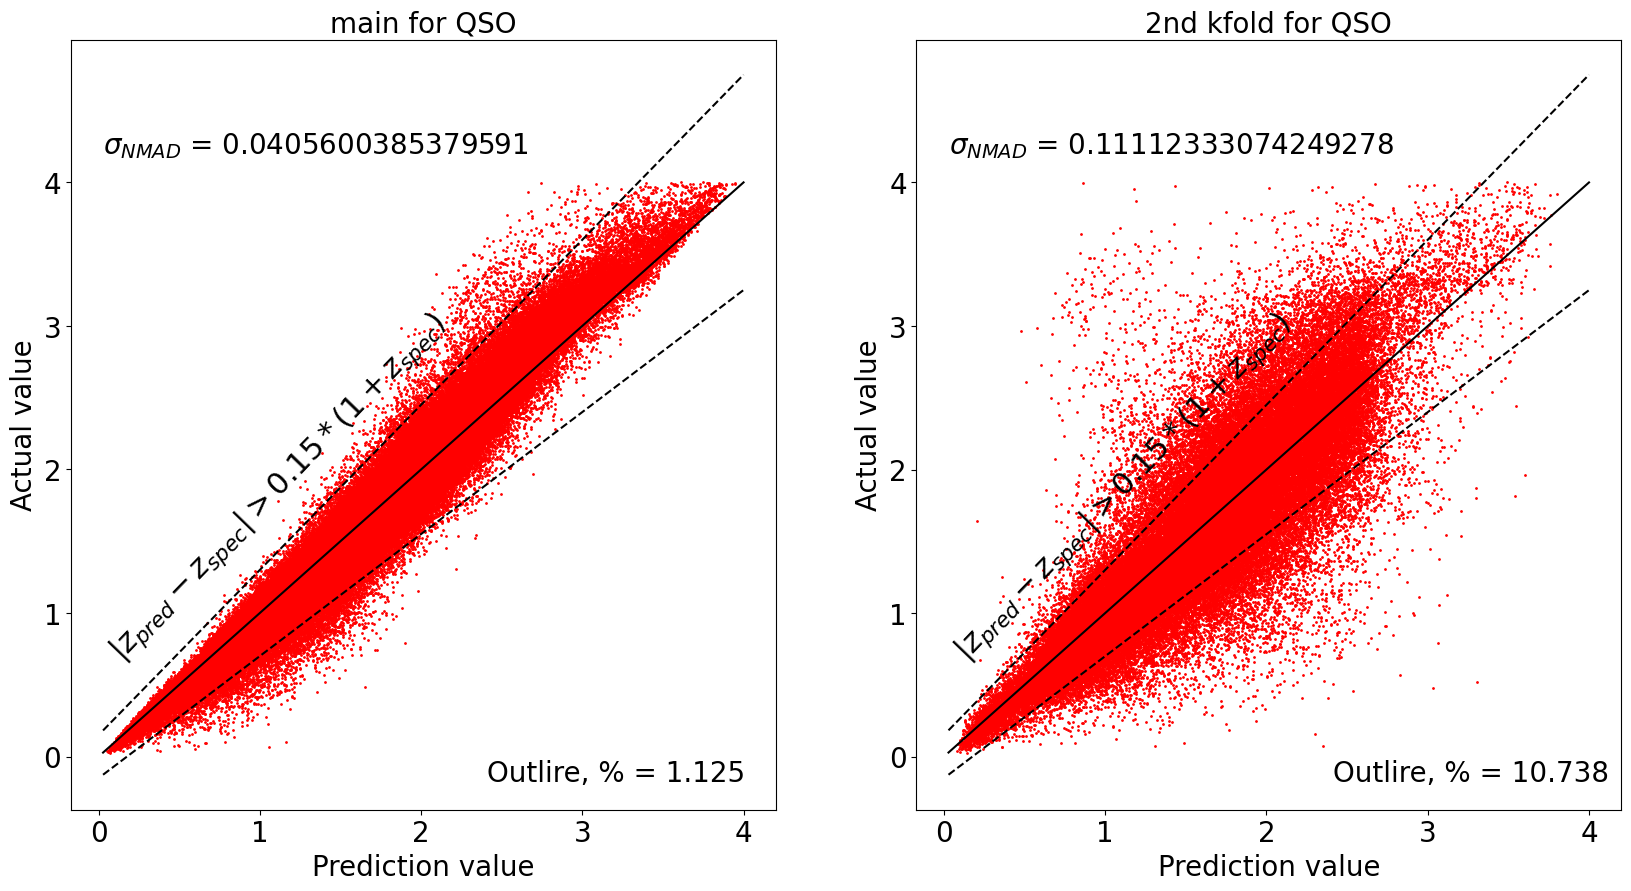

In [23]:
redshift_estimation(config_fuzzy_dist)

In [6]:
fconfig = open('config_agn_sdss_fuzzy_None_30_20_10.json')
config_None_321 = Config(fconfig)
fconfig.close()
del fconfig

fconfig = open('config_agn_sdss_fuzzy_None_50_10_30.json')
config_None_513 = Config(fconfig)
fconfig.close()
del fconfig

fconfig = open('config_agn_sdss_fuzzy_None_200_20_50.json')
config_None_2025 = Config(fconfig)
fconfig.close()
del fconfig

In [7]:
network(data,config_None_321)
network(data,config_None_513)
network(data,config_None_2025)

Sample name:  sdss_diploma_sample_dereddedcut_rangecut_flux_color_mcdcut_cbalancedfalse_wbalanced_e1_v02_arelu_erecall_ldropout_fuzzy_None_30_20_10
Features:  {'astrometry': ['angDist', 'PQSO', 'PGal', 'PSS'], 'flux': ['nW1', 'FW1pm', 'e_FW1pm', 'nW2', 'FW2pm', 'e_FW2pm', 'o_Gmag', 'FG', 'e_FG', 'o_BPmag', 'FBP', 'e_FBP', 'o_RPmag', 'FRP', 'e_FRP'], 'photometry': ['W1mproPM', 'e_W1mproPM', 'W2mproPM', 'e_W2mproPM', 'Gmag', 'e_Gmag', 'BPmag', 'e_BPmag', 'RPmag', 'e_RPmag']}
class weights {0: 0.5069758293997523, 1: 11.318292227204783, 2: 8.05632397925256, 3: 2.162741294361269, 4: 0.48256051706374076, 5: 0.7810146982980918}
                 RA        DEC         z     z_err   angDist  angDist.1   
0        239.177460  27.055966  0.090353  0.000027  0.086462   0.171325  \
1        169.268150   4.427474  1.170077  0.000150  0.032336   0.068488   
2         43.250305  -3.342976  0.244153  0.000030  0.200110   0.594563   
3        172.780700  45.426833  1.229971  0.000552  0.045566   0.092679

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  30 out of  30 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  30 out of  30 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 co

gpu
model compiled
639/639 [==============================] - 2s 3ms/step - loss: 0.7762 - tp: 586059.0000 - fp: 48487.0000 - tn: 4040358.0000 - fn: 231710.0000 - accuracy: 0.9429 - precision: 0.9236 - recall: 0.7167 - auc: 0.9742 - prc: 0.9117 - weighted_accuracy: 0.6628 - val_loss: 0.3576 - val_tp: 132874.0000 - val_fp: 6302.0000 - val_tn: 811468.0000 - val_fn: 30680.0000 - val_accuracy: 0.9623 - val_precision: 0.9547 - val_recall: 0.8124 - val_auc: 0.9884 - val_prc: 0.9578 - val_weighted_accuracy: 0.8952
model fited
Model is saved to disk

Model is loaded from disk

267/267 [==============================] - 0s 527us/step


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  30 out of  30 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  30 out of  30 | elapsed:    0.0s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  30 out of  30 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  30 out of  30 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 co

gpu
model compiled
639/639 [==============================] - 2s 3ms/step - loss: 0.7703 - tp: 592427.0000 - fp: 41846.0000 - tn: 4046999.0000 - fn: 225342.0000 - accuracy: 0.9455 - precision: 0.9340 - recall: 0.7244 - auc: 0.9761 - prc: 0.9185 - weighted_accuracy: 0.6676 - val_loss: 0.2970 - val_tp: 141467.0000 - val_fp: 7156.0000 - val_tn: 810614.0000 - val_fn: 22087.0000 - val_accuracy: 0.9702 - val_precision: 0.9519 - val_recall: 0.8650 - val_auc: 0.9919 - val_prc: 0.9701 - val_weighted_accuracy: 0.9137
model fited
Model is saved to disk

Model is loaded from disk

267/267 [==============================] - 0s 509us/step


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.9s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  30 out of  30 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  30 out of  30 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 co

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  30 out of  30 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  30 out of  30 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.4s re

gpu
model compiled
639/639 [==============================] - 2s 3ms/step - loss: 0.8091 - tp: 586489.0000 - fp: 47528.0000 - tn: 4041322.0000 - fn: 231281.0000 - accuracy: 0.9432 - precision: 0.9250 - recall: 0.7172 - auc: 0.9738 - prc: 0.9118 - weighted_accuracy: 0.6506 - val_loss: 0.3292 - val_tp: 137714.0000 - val_fp: 9070.0000 - val_tn: 808700.0000 - val_fn: 25840.0000 - val_accuracy: 0.9644 - val_precision: 0.9382 - val_recall: 0.8420 - val_auc: 0.9898 - val_prc: 0.9622 - val_weighted_accuracy: 0.8952
model fited
Model is saved to disk

Model is loaded from disk

267/267 [==============================] - 0s 517us/step


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.9s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  30 out of  30 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  30 out of  30 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 co

gpu
model compiled
852/852 [==============================] - 3s 2ms/step - loss: 0.7485 - tp: 760628.0000 - fp: 55265.0000 - tn: 5123940.0000 - fn: 275213.0000 - accuracy: 0.9468 - precision: 0.9323 - recall: 0.7343 - auc: 0.9774 - prc: 0.9224 - weighted_accuracy: 0.6740 - val_loss: 0.3757 - val_tp: 176110.0000 - val_fp: 13804.0000 - val_tn: 1076556.0000 - val_fn: 41962.0000 - val_accuracy: 0.9574 - val_precision: 0.9273 - val_recall: 0.8076 - val_auc: 0.9864 - val_prc: 0.9504 - val_weighted_accuracy: 0.8795
model fited
Model is saved to disk

Model is loaded from disk

1065/1065 [==============================] - 1s 511us/step


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  30 out of  30 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  30 out of  30 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 co

Sample name:  sdss_diploma_sample_dereddedcut_rangecut_flux_color_mcdcut_cbalancedfalse_wbalanced_e1_v02_arelu_erecall_ldropout_fuzzy_None_50_10_30
Features:  {'astrometry': ['angDist', 'PQSO', 'PGal', 'PSS'], 'flux': ['nW1', 'FW1pm', 'e_FW1pm', 'nW2', 'FW2pm', 'e_FW2pm', 'o_Gmag', 'FG', 'e_FG', 'o_BPmag', 'FBP', 'e_FBP', 'o_RPmag', 'FRP', 'e_FRP'], 'photometry': ['W1mproPM', 'e_W1mproPM', 'W2mproPM', 'e_W2mproPM', 'Gmag', 'e_Gmag', 'BPmag', 'e_BPmag', 'RPmag', 'e_RPmag']}
class weights {0: 0.5069758293997523, 1: 11.318292227204783, 2: 8.05632397925256, 3: 2.162741294361269, 4: 0.48256051706374076, 5: 0.7810146982980918}
                 RA        DEC         z     z_err   angDist  angDist.1   
0        239.177460  27.055966  0.090353  0.000027  0.086462   0.171325  \
1        169.268150   4.427474  1.170077  0.000150  0.032336   0.068488   
2         43.250305  -3.342976  0.244153  0.000030  0.200110   0.594563   
3        172.780700  45.426833  1.229971  0.000552  0.045566   0.092679

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   12.8s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0

gpu
model compiled
639/639 [==============================] - 2s 3ms/step - loss: 0.7720 - tp: 582393.0000 - fp: 42038.0000 - tn: 4046807.0000 - fn: 235376.0000 - accuracy: 0.9435 - precision: 0.9327 - recall: 0.7122 - auc: 0.9744 - prc: 0.9137 - weighted_accuracy: 0.6644 - val_loss: 0.3215 - val_tp: 139311.0000 - val_fp: 6641.0000 - val_tn: 811129.0000 - val_fn: 24243.0000 - val_accuracy: 0.9685 - val_precision: 0.9545 - val_recall: 0.8518 - val_auc: 0.9906 - val_prc: 0.9653 - val_weighted_accuracy: 0.9044
model fited
Model is saved to disk

Model is loaded from disk

267/267 [==============================] - 0s 509us/step


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   12.9s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0

gpu
model compiled
639/639 [==============================] - 2s 3ms/step - loss: 0.8173 - tp: 590155.0000 - fp: 53418.0000 - tn: 4035427.0000 - fn: 227614.0000 - accuracy: 0.9427 - precision: 0.9170 - recall: 0.7217 - auc: 0.9729 - prc: 0.9092 - weighted_accuracy: 0.6499 - val_loss: 0.3154 - val_tp: 139538.0000 - val_fp: 7077.0000 - val_tn: 810693.0000 - val_fn: 24016.0000 - val_accuracy: 0.9683 - val_precision: 0.9517 - val_recall: 0.8532 - val_auc: 0.9906 - val_prc: 0.9656 - val_weighted_accuracy: 0.9038
model fited
Model is saved to disk

Model is loaded from disk

267/267 [==============================] - 0s 512us/step


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   12.8s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0

gpu
model compiled
639/639 [==============================] - 3s 3ms/step - loss: 0.7869 - tp: 597993.0000 - fp: 52233.0000 - tn: 4036617.0000 - fn: 219777.0000 - accuracy: 0.9446 - precision: 0.9197 - recall: 0.7312 - auc: 0.9747 - prc: 0.9152 - weighted_accuracy: 0.6646 - val_loss: 0.3351 - val_tp: 136351.0000 - val_fp: 9569.0000 - val_tn: 808201.0000 - val_fn: 27203.0000 - val_accuracy: 0.9625 - val_precision: 0.9344 - val_recall: 0.8337 - val_auc: 0.9894 - val_prc: 0.9602 - val_weighted_accuracy: 0.8950
model fited
Model is saved to disk

Model is loaded from disk

267/267 [==============================] - 0s 516us/step


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   12.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    0.2s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1

gpu
model compiled
852/852 [==============================] - 3s 2ms/step - loss: 0.7494 - tp: 761941.0000 - fp: 60214.0000 - tn: 5118991.0000 - fn: 273900.0000 - accuracy: 0.9462 - precision: 0.9268 - recall: 0.7356 - auc: 0.9773 - prc: 0.9216 - weighted_accuracy: 0.6739 - val_loss: 0.3521 - val_tp: 180370.0000 - val_fp: 12416.0000 - val_tn: 1077944.0000 - val_fn: 37702.0000 - val_accuracy: 0.9617 - val_precision: 0.9356 - val_recall: 0.8271 - val_auc: 0.9883 - val_prc: 0.9571 - val_weighted_accuracy: 0.8933
model fited
Model is saved to disk

Model is loaded from disk

1065/1065 [==============================] - 1s 510us/step


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   17.9s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0

Sample name:  sdss_diploma_sample_dereddedcut_rangecut_flux_color_mcdcut_cbalancedfalse_wbalanced_e1_v02_arelu_erecall_ldropout_fuzzy_None_200_20_50
Features:  {'astrometry': ['angDist', 'PQSO', 'PGal', 'PSS'], 'flux': ['nW1', 'FW1pm', 'e_FW1pm', 'nW2', 'FW2pm', 'e_FW2pm', 'o_Gmag', 'FG', 'e_FG', 'o_BPmag', 'FBP', 'e_FBP', 'o_RPmag', 'FRP', 'e_FRP'], 'photometry': ['W1mproPM', 'e_W1mproPM', 'W2mproPM', 'e_W2mproPM', 'Gmag', 'e_Gmag', 'BPmag', 'e_BPmag', 'RPmag', 'e_RPmag']}
class weights {0: 0.5069758293997523, 1: 11.318292227204783, 2: 8.05632397925256, 3: 2.162741294361269, 4: 0.48256051706374076, 5: 0.7810146982980918}
                 RA        DEC         z     z_err   angDist  angDist.1   
0        239.177460  27.055966  0.090353  0.000027  0.086462   0.171325  \
1        169.268150   4.427474  1.170077  0.000150  0.032336   0.068488   
2         43.250305  -3.342976  0.244153  0.000030  0.200110   0.594563   
3        172.780700  45.426833  1.229971  0.000552  0.045566   0.09267

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   55.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.1min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.9s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    1.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    2.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Do

gpu
model compiled
639/639 [==============================] - 3s 3ms/step - loss: 0.7917 - tp: 580497.0000 - fp: 47311.0000 - tn: 4041534.0000 - fn: 237272.0000 - accuracy: 0.9420 - precision: 0.9246 - recall: 0.7099 - auc: 0.9730 - prc: 0.9093 - weighted_accuracy: 0.6574 - val_loss: 0.3500 - val_tp: 133200.0000 - val_fp: 5463.0000 - val_tn: 812307.0000 - val_fn: 30354.0000 - val_accuracy: 0.9635 - val_precision: 0.9606 - val_recall: 0.8144 - val_auc: 0.9892 - val_prc: 0.9603 - val_weighted_accuracy: 0.8920
model fited
Model is saved to disk

Model is loaded from disk

267/267 [==============================] - 0s 518us/step


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   55.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.1min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    1.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Do

gpu
model compiled
639/639 [==============================] - 2s 3ms/step - loss: 0.8130 - tp: 576430.0000 - fp: 47168.0000 - tn: 4041677.0000 - fn: 241339.0000 - accuracy: 0.9412 - precision: 0.9244 - recall: 0.7049 - auc: 0.9716 - prc: 0.9055 - weighted_accuracy: 0.6524 - val_loss: 0.3579 - val_tp: 135182.0000 - val_fp: 7323.0000 - val_tn: 810447.0000 - val_fn: 28372.0000 - val_accuracy: 0.9636 - val_precision: 0.9486 - val_recall: 0.8265 - val_auc: 0.9882 - val_prc: 0.9577 - val_weighted_accuracy: 0.8913
model fited
Model is saved to disk

Model is loaded from disk

267/267 [==============================] - 0s 515us/step


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   56.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.1min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    1.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Do

gpu
model compiled
639/639 [==============================] - 2s 2ms/step - loss: 0.7803 - tp: 588073.0000 - fp: 45662.0000 - tn: 4043188.0000 - fn: 229697.0000 - accuracy: 0.9439 - precision: 0.9279 - recall: 0.7191 - auc: 0.9759 - prc: 0.9166 - weighted_accuracy: 0.6601 - val_loss: 0.3438 - val_tp: 135879.0000 - val_fp: 8535.0000 - val_tn: 809235.0000 - val_fn: 27675.0000 - val_accuracy: 0.9631 - val_precision: 0.9409 - val_recall: 0.8308 - val_auc: 0.9888 - val_prc: 0.9590 - val_weighted_accuracy: 0.8928
model fited
Model is saved to disk

Model is loaded from disk

267/267 [==============================] - 0s 515us/step


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   55.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.1min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.9s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    1.8s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    2.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Do

gpu
model compiled
852/852 [==============================] - 3s 3ms/step - loss: 0.7757 - tp: 751510.0000 - fp: 65674.0000 - tn: 5113531.0000 - fn: 284331.0000 - accuracy: 0.9437 - precision: 0.9196 - recall: 0.7255 - auc: 0.9753 - prc: 0.9149 - weighted_accuracy: 0.6651 - val_loss: 0.3772 - val_tp: 175661.0000 - val_fp: 13615.0000 - val_tn: 1076745.0000 - val_fn: 42411.0000 - val_accuracy: 0.9572 - val_precision: 0.9281 - val_recall: 0.8055 - val_auc: 0.9861 - val_prc: 0.9491 - val_weighted_accuracy: 0.8777
model fited
Model is saved to disk

Model is loaded from disk

1065/1065 [==============================] - 1s 519us/step


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.5min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    3.7s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    4.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    2.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Do

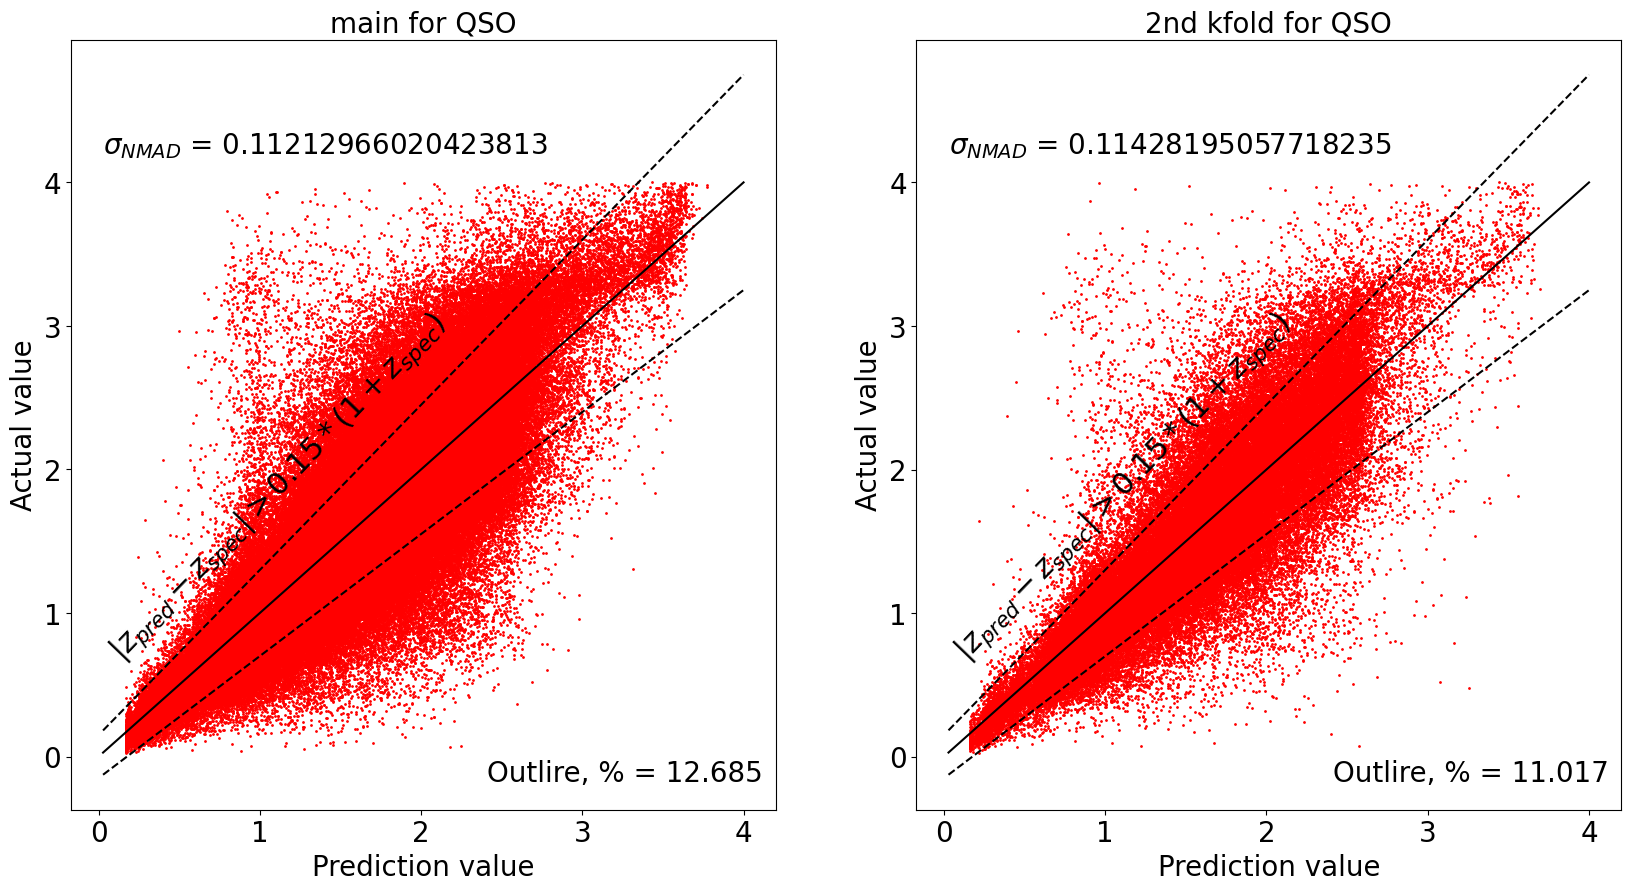

In [11]:
redshift_estimation(config_None_321)

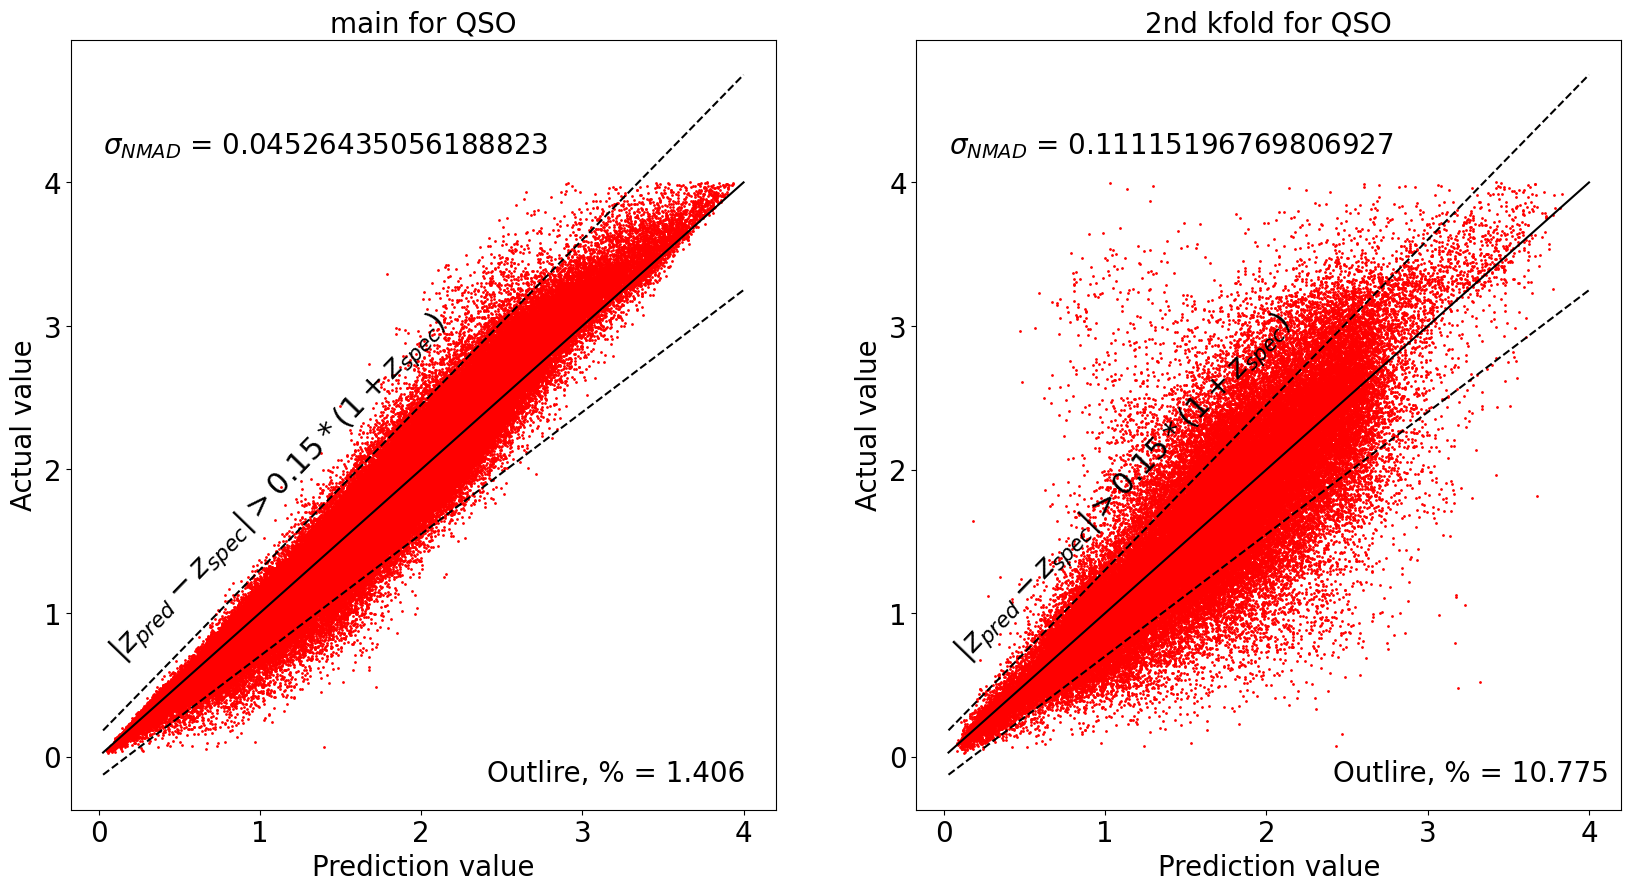

In [12]:
redshift_estimation(config_None_513)

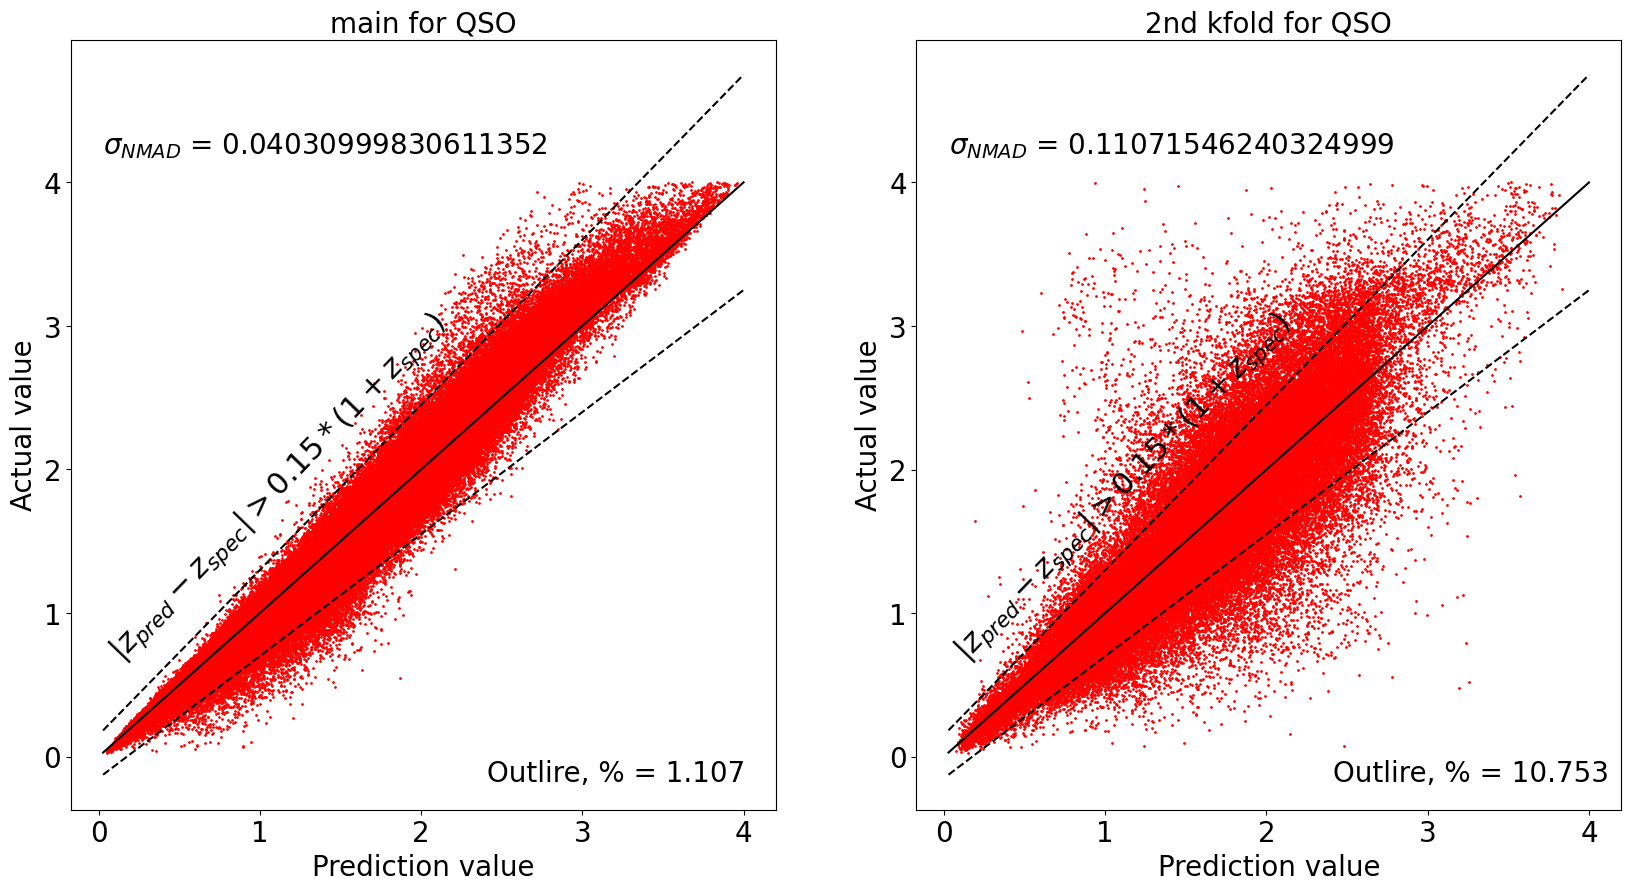

In [13]:
redshift_estimation(config_None_2025)